# Funciones auxiliares

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import copy
import matplotlib.pyplot as plt
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Entrenamientos

In [2]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento. 
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  best_err = 1

  errors_train, errors_val, errors_test = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_val = red.predict(X_val)
    error_val = errorFunc(y_val, pred_val)
    errors_val.append(error_val)

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    if error_val < best_err:
      best_err = error_val
      best_red = copy.deepcopy(red)

  return best_red, errors_train, errors_val, errors_test

In [3]:
def entrenar_red2(red, evaluaciones, X_train, y_train, X_test, y_test):
  if type(red) == MLPClassifier:
    errorFunc = sk.metrics.zero_one_loss
  else:
    errorFunc = sk.metrics.mean_squared_error

  errors_train, errors_test, weights = [], [], []
  for n in range(evaluaciones):
    red.fit(X_train, y_train)
    
    pred_train = red.predict(X_train)
    errors_train.append(errorFunc(y_train, pred_train))

    pred_test = red.predict(X_test)
    errors_test.append(errorFunc(y_test, pred_test))

    weights.append(np.sum([np.sum(np.square(w)) for w in red.coefs_]))

  return red, errors_train, errors_test, weights

## Generadores

In [4]:
def centroGauss(d, v):
  return [v]*d

def covMatrix(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrix(d, C)
  valores0 = np.random.multivariate_normal(centroGauss(d, -1), matriz, n0)
  valores1 = np.random.multivariate_normal(centroGauss(d, 1), matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [5]:
def covMatrixP(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  n1 = n - n0
  matriz = covMatrixP(d, C)
  centro = centroGauss(d, 0)
  centro[0] = -1
  valores0 = np.random.multivariate_normal(centro, matriz, n0)
  centro[0] = 1
  valores1 = np.random.multivariate_normal(centro, matriz, n1)

  data = [[0, *x] for x in valores0] + [[1, *x] for x in valores1]

  return pd.DataFrame(data, columns=['Target', *['d' + str(x + 1) for x in range(d)]])

In [6]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*np.pi) / (4 * np.pi)
  rho_curve2 = (theta + npi*np.pi) / (4 * np.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  n0 = int(n/2)
  n1 = n - n0
  i0, i1 = 0, 0
  values0, values1 = [], []
  while (i0 + i1 < n):
    x, y = np.random.uniform(-1, 1, 2)
    if (np.sqrt(x**2 + y**2) > 1):
      continue
    if (is_inside_curves(x, y)):
      if (i0 != n0):
        values0.append([x, y])
        i0 += 1
    else:
      if (i1 != n1):
        values1.append([x, y])
        i1 += 1

  data = [[0, *x] for x in values0] + [[1, *x] for x in values1]

  return pd.DataFrame(data, columns=['Target', 'd1', 'd2'])

## Plots

In [7]:
def plotGrafico(title, x, y):
  i, n = 0, len(y)
  xs0, ys0, xs1, ys1 = [], [], [], []
  while (i < n):
    if (y[i] == 0):
      xs0.append(x[i][0])
      ys0.append(x[i][1])
    else:
      xs1.append(x[i][0])
      ys1.append(x[i][1])
    i += 1

  plt.scatter(xs0, ys0, color='red', facecolors='none', label='Clase 0')
  plt.scatter(xs1, ys1, color='green', facecolors='none', label='Clase 1')
  plt.legend()
  plt.title(title)
  plt.show()

In [8]:
def plotEntrenamiento(title, arbol, ann, nb, dimentions):
  plt.figure(figsize=(20,12))
  
  plt.plot(dimentions, arbol[0], linestyle="-", label='Tree Train')
  plt.plot(dimentions, arbol[1], linestyle="-", label='Tree Test')
  plt.plot(dimentions, ann[0], linestyle="-", label='ANN Train')
  plt.plot(dimentions, ann[1], linestyle="-", label='ANN Test')
  plt.plot(dimentions, nb[0], linestyle="-", label='NB Train')
  plt.plot(dimentions, nb[1], linestyle="-", label='NB Test')

  plt.scatter(dimentions, arbol[0], color='blue', s=50)
  plt.scatter(dimentions, arbol[1], color='orange', s=50)
  plt.scatter(dimentions, ann[0], color='green', s=50)
  plt.scatter(dimentions, ann[1], color='red', s=50)
  plt.scatter(dimentions, nb[0], color='pink', s=50)
  plt.scatter(dimentions, nb[1], color='grey', s=50)

  plt.xticks(dimentions, labels=[str(i) for i in dimentions])
  plt.legend()
  plt.title(title)
  plt.show()

In [9]:
def plotEntrenamiento1(title, arbol_diag, arbol_para, ann_diag, ann_para, nb_diag, nb_para, dimentions):
  plt.figure(figsize=(20,12))
  
  plt.plot(dimentions, arbol_diag[0], label='Diagonal Tree Train', linestyle="-")
  plt.plot(dimentions, arbol_diag[1], label='Diagonal Tree Test', linestyle="-")
  plt.plot(dimentions, arbol_para[0], label='Paralel Tree Train', linestyle="-")
  plt.plot(dimentions, arbol_para[1], label='Paralel Tree Test', linestyle="-")
  plt.plot(dimentions, ann_diag[0], label='Diagonal ANN Train', linestyle="-")
  plt.plot(dimentions, ann_diag[1], label='Diagonal ANN Test', linestyle="-")
  plt.plot(dimentions, ann_para[0], label='Paralel ANN Train', linestyle="-")
  plt.plot(dimentions, ann_para[1], label='Paralel ANN Test', linestyle="-")
  plt.plot(dimentions, nb_diag[0], label='Diagonal NB Train', linestyle="-")
  plt.plot(dimentions, nb_diag[1], label='Diagonal NB Test', linestyle="-")
  plt.plot(dimentions, nb_para[0], label='Paralel NB Train', linestyle="-")
  plt.plot(dimentions, nb_para[1], label='Paralel NB Test', linestyle="-")
  
  plt.scatter(dimentions, arbol_diag[0], color='blue', s=50)
  plt.scatter(dimentions, arbol_diag[1], color='orange', s=50)
  plt.scatter(dimentions, arbol_para[0], color='green', s=50)
  plt.scatter(dimentions, arbol_para[1], color='red', s=50)
  plt.scatter(dimentions, ann_diag[0], color='purple', s=50)
  plt.scatter(dimentions, ann_diag[1], color='brown', s=50)
  plt.scatter(dimentions, ann_para[0], color='pink', s=50)
  plt.scatter(dimentions, ann_para[1], color='grey', s=50)
  plt.scatter(dimentions, nb_diag[0], color='black', s=50)
  plt.scatter(dimentions, nb_diag[1], color='yellow', s=50)
  plt.scatter(dimentions, nb_para[0], color='magenta', s=50)
  plt.scatter(dimentions, nb_para[1], color='cyan', s=50)

  plt.xticks(dimentions, labels=[str(i) for i in dimentions])
  plt.legend()
  plt.title(title)
  plt.show()

In [10]:
def plotEntrenamiento2(title, error_train, error_val, error_test, rango):
  plt.figure(figsize=(20,12))
  plt.plot(rango, error_train, label="Train", linestyle=":")
  plt.plot(rango, error_val, label="Val", linestyle="-.")
  plt.plot(rango, error_test, label="Test", linestyle="-")
  
  plt.legend()
  plt.title(title)
  plt.show()

# Ejercicio 1


In [ ]:
dimensiones = [2, 4, 8, 16, 32]
learning_rate = 0.1
momentum = 0.9
weight_decay = 10**(-4)
sub_epocas = 50
cant_epocas = 300
neuronas = 6

errorPara = {}
errorDiag = {}
errorParaANN = {}
errorDiagANN = {}
errorParaNB = {}
errorDiagNB = {}

## Calculos

In [21]:
for i in dimensiones:
  test = diagonales(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN, errorNB = [], [], []

  for _ in range(20):
    train = diagonales(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

    clf = GaussianNB()

    clf.fit(xTrain, yTrain)

    errorNB.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

  errorDiag[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorDiagANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))
  errorDiagNB[i] = (np.average([x for x, y in errorNB]), np.average([y for x, y in errorNB]))

In [22]:
for i in dimensiones:
  test = paralelas(10000, i, 0.78)

  xTest = test[['d' + str(n + 1) for n in range(i)]].values
  yTest = test['Target'].values

  errorTree, errorANN, errorNB = [], [], []

  for _ in range(20):
    train = paralelas(250, i, 0.78)

    xTrain = train[['d' + str(n + 1) for n in range(i)]].values
    yTrain = train['Target'].values

    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    clf.fit(xTrain, yTrain)

    errorTree.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

    clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=weight_decay, batch_size=1, learning_rate='constant', learning_rate_init=learning_rate, 
                          momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)
    
    _, error_train, error_test, _ = entrenar_red2(clasif, cant_epocas, xTrain, yTrain, xTest, yTest)

    errorANN.append((error_train[-1], error_test[-1]))

    clf = GaussianNB()

    clf.fit(xTrain, yTrain)

    errorNB.append((1 - clf.score(xTrain, yTrain), 1 - clf.score(xTest, yTest)))

  errorPara[i] = (np.average([x for x, y in errorTree]), np.average([y for x, y in errorTree]))
  errorParaANN[i] = (np.average([x for x, y in errorANN]), np.average([y for x, y in errorANN]))
  errorParaNB[i] = (np.average([x for x, y in errorNB]), np.average([y for x, y in errorNB]))

## Graficos

In [34]:
errDiagArbol = ([v[0] for k, v in errorDiag.items()], [v[1] for k, v in errorDiag.items()])
errParaArbol = ([v[0] for k, v in errorPara.items()], [v[1] for k, v in errorPara.items()])
errDiagANN = ([v[0] for k, v in errorDiagANN.items()], [v[1] for k, v in errorDiagANN.items()])
errParaANN = ([v[0] for k, v in errorParaANN.items()], [v[1] for k, v in errorParaANN.items()])
errDiagNB = ([v[0] for k, v in errorDiagNB.items()], [v[1] for k, v in errorDiagNB.items()])
errParaNB = ([v[0] for k, v in errorParaNB.items()], [v[1] for k, v in errorParaNB.items()])

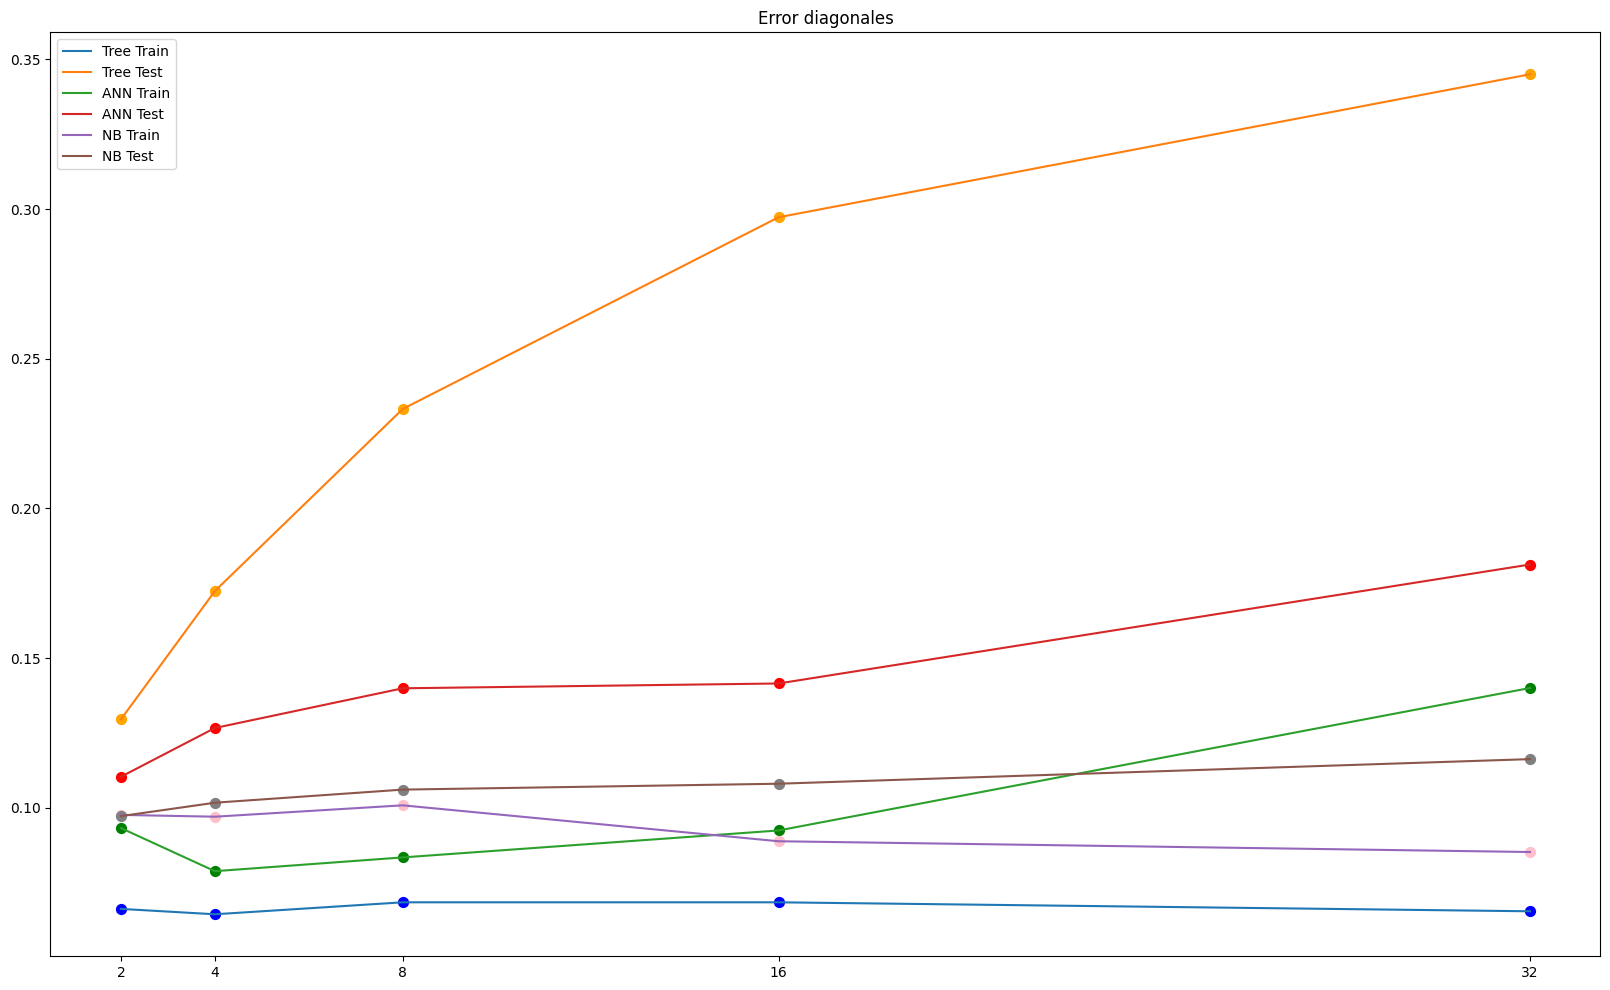

In [35]:
plotEntrenamiento("Error diagonales", errDiagArbol, errDiagANN, errDiagNB, dimensiones)

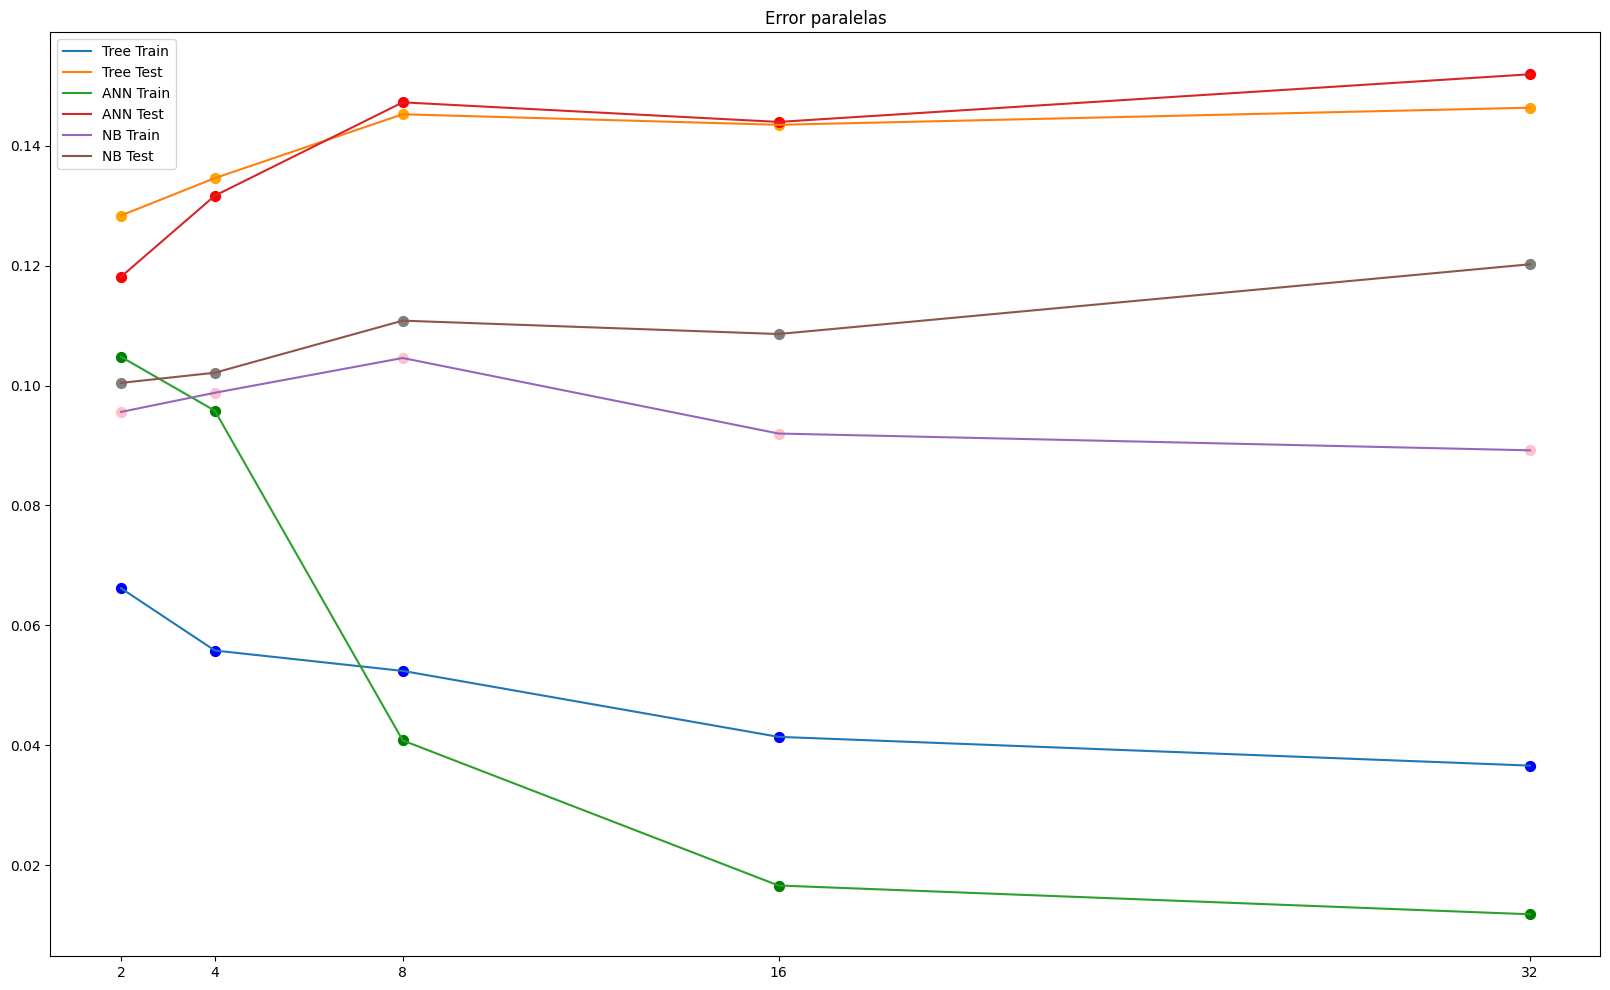

In [36]:
plotEntrenamiento("Error paralelas", errParaArbol, errParaANN, errParaNB, dimensiones)

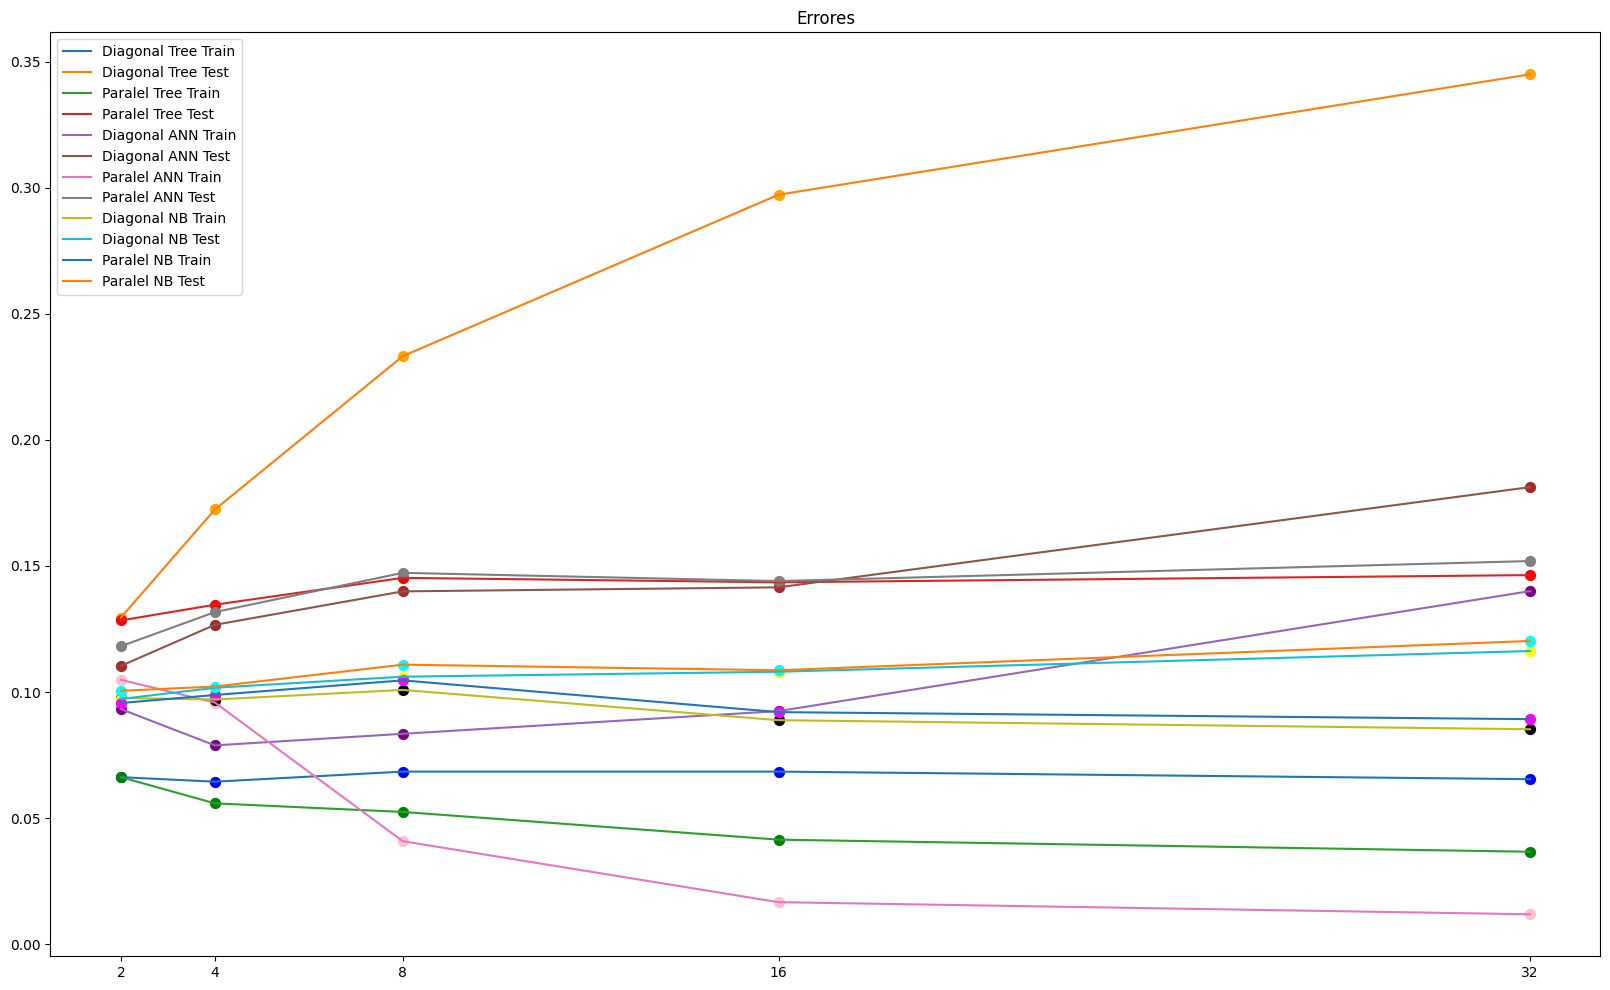

In [37]:
plotEntrenamiento1("Errores", errDiagArbol, errParaArbol, errDiagANN, errParaANN, errDiagNB, errParaNB, dimensiones)

## Comentarios

Como se puede ver en ambos gráficos, Naive Bayes consiguió un error de test más bajo que los otros dos modelos. También se puede notar que el error de validación tiende a ser más alto que el de los otros modelos.

Aunque esta diferencia pueda parecer extraña, no lo considero un problema. Al contrario, esto podría estar reflejando la ausencia de sobreentrenamiento en comparación con los otros dos modelos.

No está de más aclarar que, a Naive Bayes probablemente le es tan fácil clasificar estos casos (tan cerca del error mínimo que planteamos en el TP1) porque estamos lidiando con distribuciones gaussianas y al estar trabajando con valores continuos, este modelo busca estas mismas distribuciones.

# Ejercicio 2

## Dos Elipses

In [38]:
data = pd.read_csv('./dos_elipses.data', header=None, names=['x', 'y', 'Target'])
test = pd.read_csv('./dos_elipses.test', header=None, names=['x', 'y', 'Target'])

dataDF = data.sample(n=500)

xTrain, xVal, yTrain, yVal = train_test_split(dataDF[['x', 'y']].values, dataDF['Target'].values, test_size=0.2)

xTest = test[['x', 'y']].values
yTest = test['Target'].values

In [13]:
momentum = 0.9
learning_rate = 0.1
sub_epoca = 50
cant_epocas = 300

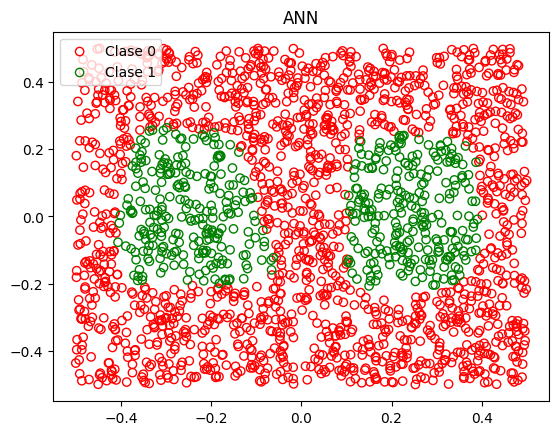

In [26]:
clasif = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', 
                       learning_rate_init=learning_rate, momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epoca)

best_red, errors_train, errors_val, errors_test = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotGrafico("ANN", xTest, best_red.predict(xTest))

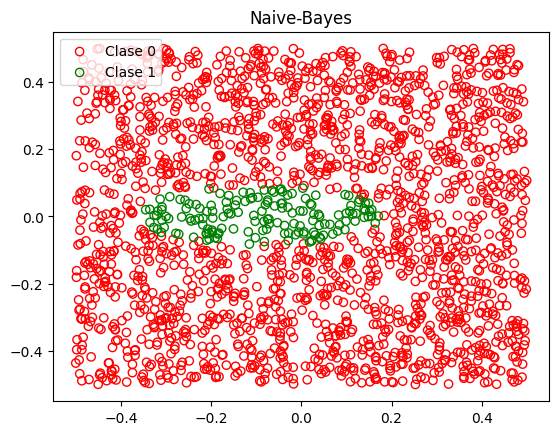

In [51]:
clf = GaussianNB()

clf.fit(np.concatenate((xTrain, xVal), axis=0), np.concatenate((yTrain, yVal), axis=0))

plotGrafico("Naive-Bayes", xTest, clf.predict(xTest))

### Comentarios

Es claro que utilizar Naive Bayes para este ejemplo no es para nada útil. Puede que la distribución en el eje y no resulte en un problema para el modelo, ya que se podría suponer que hay una "distribución gaussiana" al estar los puntos más centrados en el medio. Pero al ver el eje x, con valores de una clase en el medio y en los límites izquierdo y derecho, y los de la otra clase en los lugares faltantes, al modelo se le debe hacer imposible predecir con una buena exactitud la clase de los casos de test.

## Espirales Anidadas

In [55]:
train = espirales(480)
xTrain = train[['d1', 'd2']].values
yTrain = train['Target'].values

val = espirales(120)
xVal = val[['d1', 'd2']].values
yVal = val['Target'].values

test = espirales(2000)
xTest = test[['d1', 'd2']].values
yTest = test['Target'].values

In [42]:
learning_rate = 0.1
momentum = 0.9
sub_epocas = 20
cant_epocas = 1000
neuronas = 40

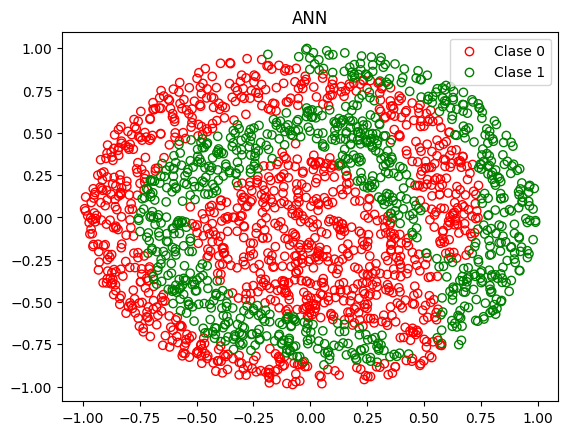

In [51]:
clasif = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', 
                       learning_rate_init=learning_rate, momentum=momentum, nesterovs_momentum=False, tol=0.0, warm_start=True, max_iter=sub_epocas)

best_red, _, _, _ = entrenar_red(clasif, cant_epocas, xTrain, yTrain, xVal, yVal, xTest, yTest)

plotGrafico("ANN", xTest, best_red.predict(xTest))

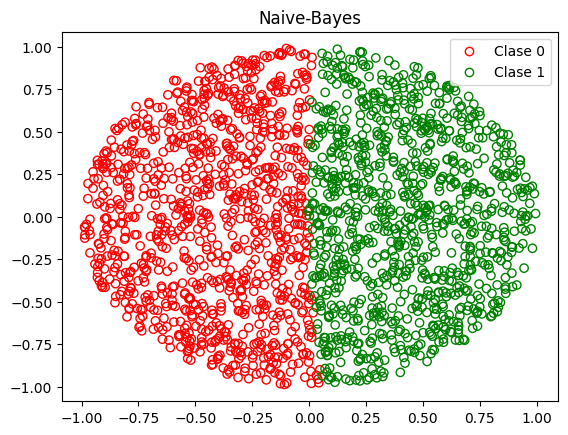

In [56]:
clf = GaussianNB()

clf.fit(np.concatenate((xTrain, xVal), axis=0), np.concatenate((yTrain, yVal), axis=0))

plotGrafico("Naive-Bayes", xTest, clf.predict(xTest))

### Comentarios

Este caso para Naive Bayes es algo caótico. Aunque los datos presenten un patrón claro, este modelo no es capaz de predecirlo correctamente al no presentar ningún tipo de distribución gaussiana. Como las muestras de cada clase no están concentradas por separado de la otra, lo mejor que puede hacer el modelo es predecir la clase de una muestra según el sector donde se presentaban mayormente muestras de cada clase.

Básicamente, como una de las premisas de Naive Bayes es que los atributos de cada muestra son independientes entre sí, al no ser el caso en este gráfico, este modelo terminó prediciendo que los elementos de la clase 1 están ubicados según una distribución gaussiana con el centro en (x>>1, y~0) y una varianza dada.

# Ejercicio 3

In [14]:
def trainNBDiscrete(xTrain, yTrain, xVal, yVal, xTest, yTest, binsN):
    maxError = 1
    errorsTrain, errorsVal, errorsTest = [], [], []
    for bins in binsN:
        discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        
        xTrainDiscrete = discretizer.fit_transform(xTrain)
        xValDiscrete = discretizer.transform(xVal)
        xTestDiscrete = discretizer.transform(xTest)

        clf = CategoricalNB(min_categories=bins)
        clf.fit(xTrainDiscrete, yTrain)

        errorsTrain.append(sk.metrics.zero_one_loss(yTrain, clf.predict(xTrainDiscrete)))

        errorVal = sk.metrics.zero_one_loss(yVal, clf.predict(xValDiscrete))
        errorsVal.append(errorVal)

        errorsTest.append(sk.metrics.zero_one_loss(yTest, clf.predict(xTestDiscrete)))

        if errorVal < maxError:
            maxError = errorVal
            bestDiscretizer = copy.deepcopy(discretizer)
            bestClasifier = copy.deepcopy(clf)
        
    return errorsTrain, errorsVal, errorsTest, bestDiscretizer, bestClasifier

# Ejercicio 4

## Dos Elipses

In [55]:
data = pd.read_csv('./dos_elipses.data', header=None, names=['x', 'y', 'Target'])
test = pd.read_csv('./dos_elipses.test', header=None, names=['x', 'y', 'Target'])

dataDF = data.sample(n=500)

xTrain, xVal, yTrain, yVal = train_test_split(dataDF[['x', 'y']].values, dataDF['Target'].values, test_size=0.2)

xTest = test[['x', 'y']].values
yTest = test['Target'].values

In [56]:
binsN = [n for n in range(2, 100)]

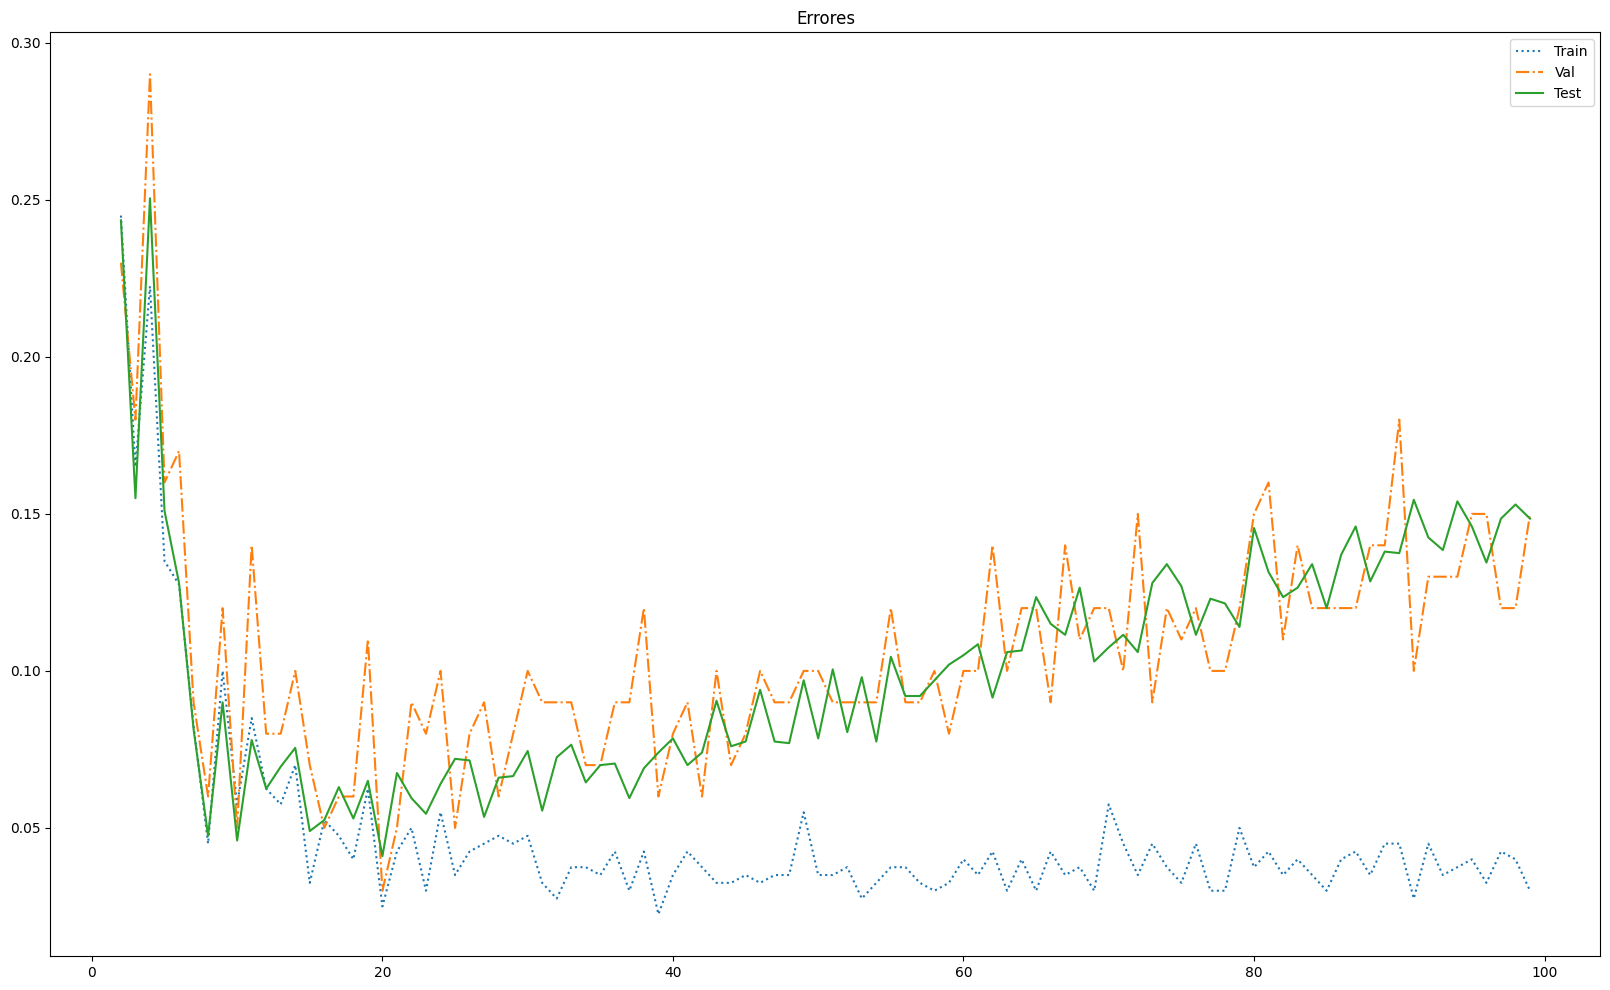

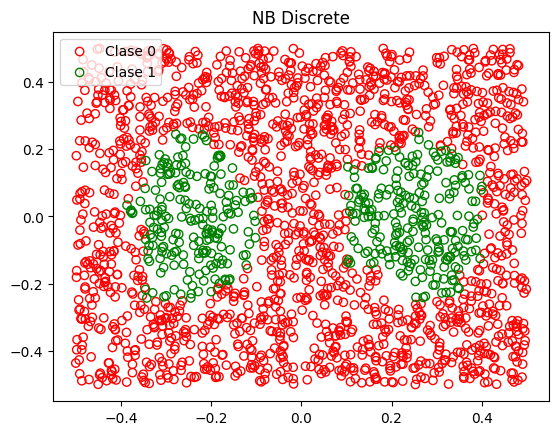

In [57]:
errorTrain, errorVal, errorTest, discretizer, clasifier = trainNBDiscrete(xTrain, yTrain, xVal, yVal, xTest, yTest, binsN)

plotEntrenamiento2("Errores", errorTrain, errorVal, errorTest, binsN)

plotGrafico("NB Discrete", xTest, clasifier.predict(discretizer.transform(xTest)))

### Comentarios

Como se puede ver, al hacer la discretización de los atributos, se consiguieron mejores resultados. Considero que al discretizarlos, los atributos de cada muestra comenzaron a presentar cierta independencia y, como las clases están tan bien delimitadas, se logró predecir más adecuadamente la clase de estas.

Uno inicialmente pensaría que al haber más divisiones (más bins), el error de testeo bajaría constantemente, pero si esta gran cantidad de bins no viene acompañada de un gran conjunto de entrenamiento, habrá muestras que no se podrán predecir, ya que estarán ubicadas en sectores donde no hubo casos de entrenamiento. De esta manera, desde los 10 hasta los 20 bins, el error de test se mantuvo en un mínimo y después comenzó a subir debido a un sobreajuste.

## Espirales Anidadas

In [49]:
train = espirales(480)
xTrain = train[['d1', 'd2']].values
yTrain = train['Target'].values

val = espirales(120)
xVal = val[['d1', 'd2']].values
yVal = val['Target'].values

test = espirales(2000)
xTest = test[['d1', 'd2']].values
yTest = test['Target'].values

In [50]:
binsN = [n for n in range(2, 200)]

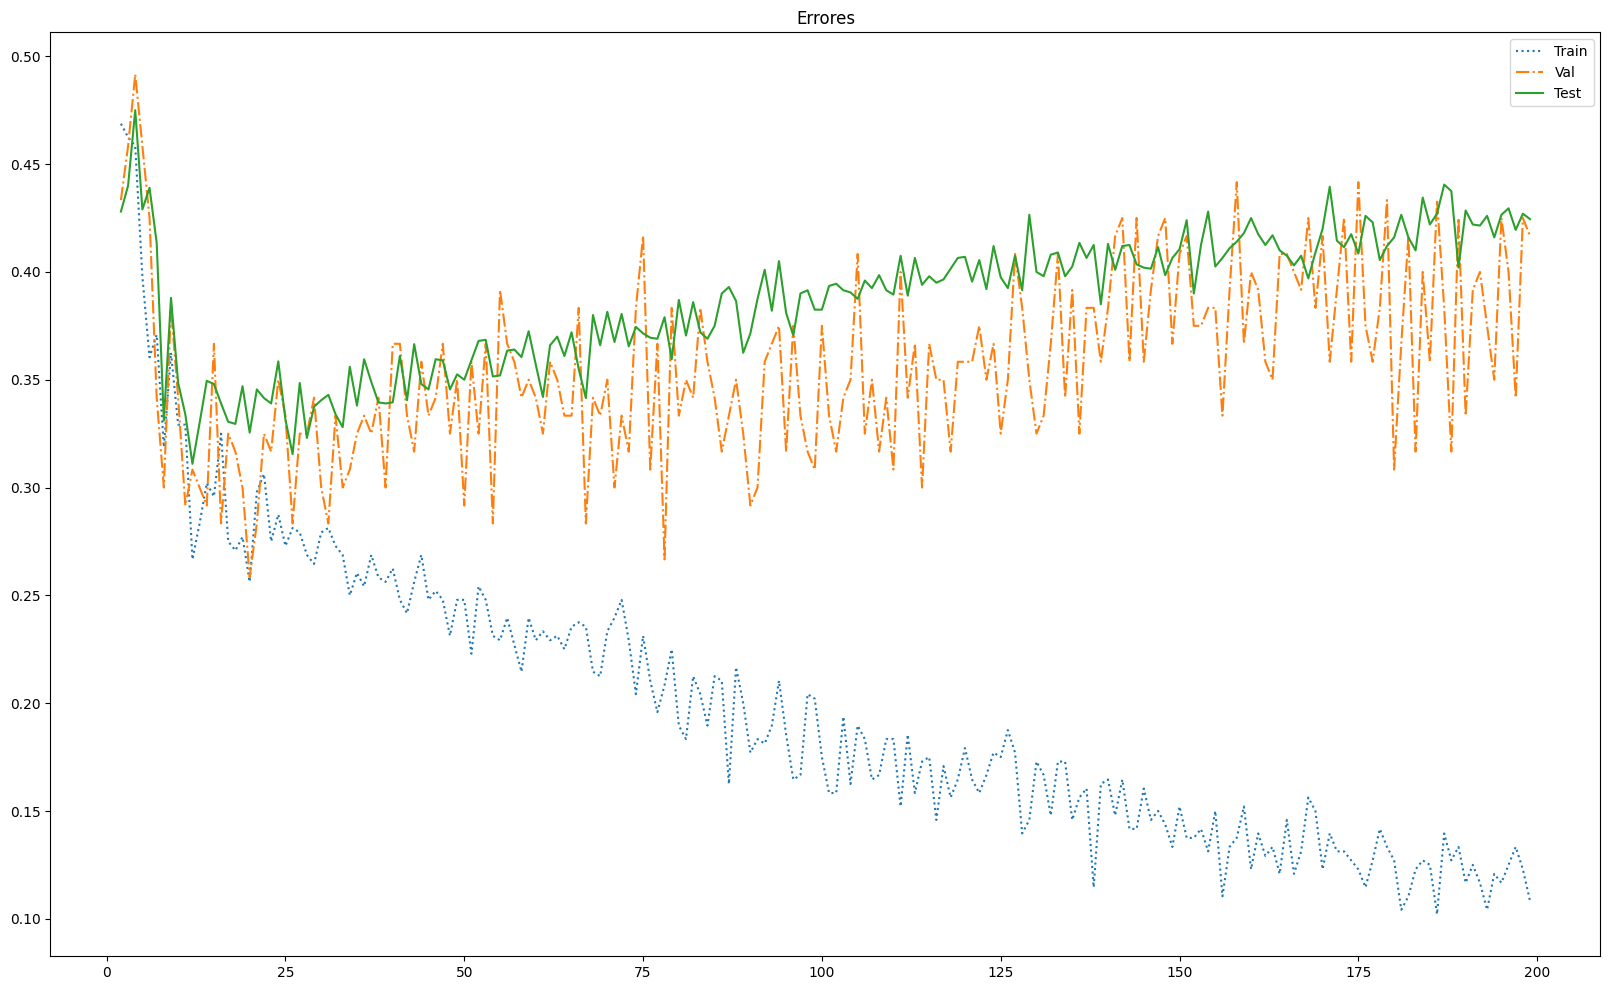

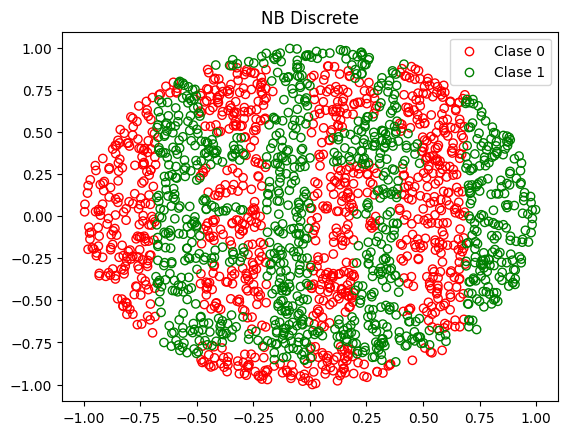

In [51]:
errorTrain, errorVal, errorTest, discretizer, clasifier = trainNBDiscrete(xTrain, yTrain, xVal, yVal, xTest, yTest, binsN)

plotEntrenamiento2("Errores", errorTrain, errorVal, errorTest, binsN)

plotGrafico("NB Discrete", xTest, clasifier.predict(discretizer.transform(xTest)))

### Comentarios

Al igual que en el caso de Dos Elipses, aquí también se observa una clara mejoría en la predicción de las clases utilizando Discretización en vez de Gaussianas. Como se puede observar en el gráfico, las clases están claramente delimitadas por líneas rectas (verticales y horizontales), lo cual se debe a la discretización de los valores.

Cerca de 17 o 18 bins se alcanza el mínimo error de test, y luego comienza a subir junto con el de validación, mientras el de entrenamiento baja. Esto muestra una clara presencia de sobreajuste.

# Ejercicio 5

In [11]:
x, y = fetch_20newsgroups(subset="train", return_X_y=True, remove=("headers",))
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.25, random_state=1)
xTest, yTest = fetch_20newsgroups(subset="test", return_X_y=True, remove=("headers",))

In [12]:
def multinomial(xTrain, yTrain, xVal, yVal, xTest, yTest, sizeDicts, alfas):
    values = {}
    minError = 1

    for sizeDict in sizeDicts:
        vec = CountVectorizer(stop_words='english',max_features=sizeDict)
        Xvec_train = vec.fit_transform(xTrain).toarray()
        Xvec_val = vec.transform(xVal).toarray()
        Xvec_test = vec.transform(xTest).toarray()

        for alfa in alfas:
            clf = MultinomialNB(alpha=alfa)
            clf.fit(Xvec_train, yTrain)

            errorTrain = sk.metrics.zero_one_loss(yTrain, clf.predict(Xvec_train))
            
            errorVal = sk.metrics.zero_one_loss(yVal, clf.predict(Xvec_val))
            
            errorTest = sk.metrics.zero_one_loss(yTest, clf.predict(Xvec_test))

            if errorVal < minError:
                minError = errorVal
                bestClassifier = copy.deepcopy(clf)
                bestVector = copy.deepcopy(vec)
                bestDict = sizeDict
                bestAlfa = alfa

            values[(sizeDict, alfa)] = {'errorTrain': errorTrain, 'errorVal': errorVal, 'errorTest': errorTest}

    return values, bestClassifier, bestVector, bestDict, bestAlfa

In [13]:
sizeDicts, alfas = [n*1000 for n in range(1, 11)], [10**(-n) for n in range(5)]

In [14]:
values, bestClassifier, bestVector, bestSizeDict, bestAlfa = multinomial(xTrain, yTrain, xVal, yVal, xTest, yTest, sizeDicts, alfas)

    Size Dict    Alfa  Error Train  Error Val  Error Test
0        1000  1.0000     0.277666   0.353482    0.413436
1        1000  0.1000     0.268120   0.346766    0.409320
2        1000  0.0100     0.264467   0.347473    0.407993
3        1000  0.0010     0.262699   0.347826    0.411312
4        1000  0.0001     0.261402   0.350654    0.414100
5        2000  1.0000     0.205421   0.285260    0.345061
6        2000  0.1000     0.190572   0.284199    0.342007
7        2000  0.0100     0.183736   0.286320    0.346654
8        2000  0.0010     0.178786   0.288088    0.354222
9        2000  0.0001     0.176547   0.293743    0.360993
10       3000  1.0000     0.172068   0.253800    0.314790
11       3000  0.1000     0.154979   0.253093    0.315852
12       3000  0.0100     0.143901   0.255567    0.324084
13       3000  0.0010     0.138362   0.259809    0.333112
14       3000  0.0001     0.135180   0.269000    0.342406
15       4000  1.0000     0.155097   0.233298    0.296601
16       4000 

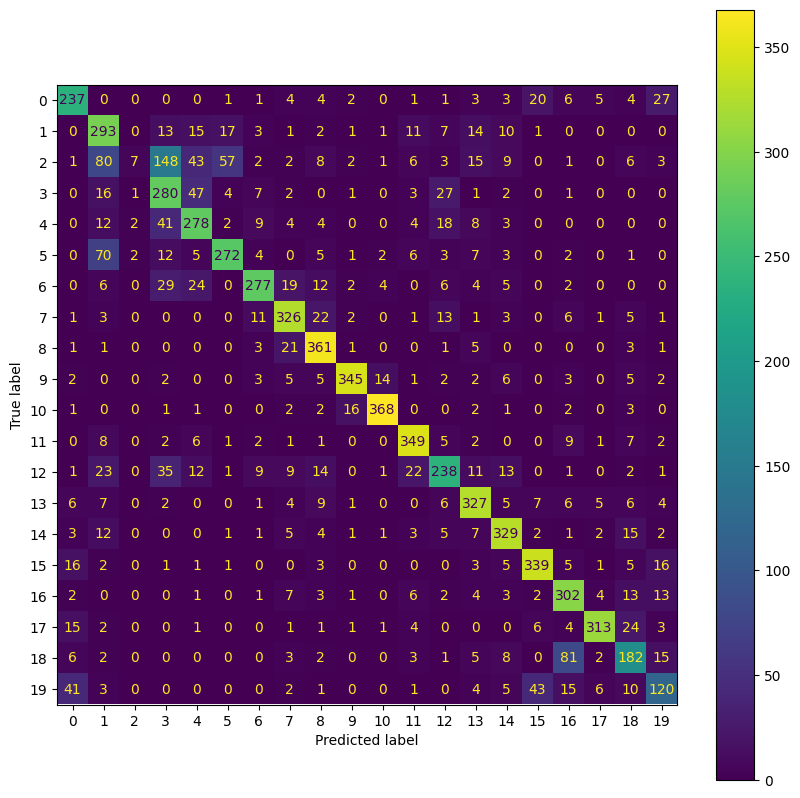

Mejor entrenamiento con sizeDict 10000 y alfa 0.01


In [15]:
valoresFinales = []

for sd, a in [(sd, a) for sd in sizeDicts for a in alfas]:
  valoresFinales.append((sd, a, values[(sd, a)]["errorTrain"], values[(sd, a)]["errorVal"], values[(sd, a)]["errorTest"]))
  
valoresDF = pd.DataFrame(valoresFinales, columns=['Size Dict', 'Alfa', 'Error Train', 'Error Val', 'Error Test'])

print(valoresDF)

cm = confusion_matrix(yTest, bestClassifier.predict(bestVector.transform(xTest).toarray()), labels=bestClassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bestClassifier.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

print(f'Mejor entrenamiento con sizeDict {bestSizeDict} y alfa {bestAlfa}')

## Comentarios

De la tabla podemos concluir que al aumentar el tamaño del diccionario, al menos hasta el punto en que lo aumente, se consigue un mejor entrenamiento. Considero que esto se debe a que, al ser más grande el diccionario, se puede realizar un mejor entrenamiento, lo cual se refleja en menores errores tanto de validación como de testeo. En cuanto al alfa, 0.1 y 0.01 parecen ser los mejores valores para utilizar.

Generando la matriz de confusión a partir del mejor entrenamiento, se puede ver que en casi todas las clases se consigue una buena predicción, mientras que para la clase 2 casi siempre tiende a predecirse mal. Esto también ocurre con la clase 19, donde la precisión es menor a 0.5.